In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Note: all these functions can be found in the 'inorg_b' module
# https://github.com/oscarbranson/Farmer_2018_Supplement/tree/master/inorg_b
from inorg_b import phreeqpy_fns as pf
from inorg_b.MyAMI_V3 import MyAMI_K_calc
from inorg_b import load
from inorg_b.phreeqpy_fns import calc_cb_rows

# Note: These functions are available in the 'cbsyst' carbon/boron speciation calculator
# https://github.com/oscarbranson/cbsyst
from cbsyst import Csys, Bsys, non_MyAMI_constants

# presentation niceties
idx = pd.IndexSlice
pd.options.mode.chained_assignment = None
plt.rcParams['figure.dpi'] = 120

# Supplement 1: Solution speciation calculation methods

### Load Data

In [2]:
rd = load.raw_data()
rd.sort_index(inplace=True)

## Calculate C and B Speciation

In [3]:
# empty dataframe for results
calc = pd.DataFrame(index=rd.index, columns=pd.MultiIndex.from_product([[''],['']]))
databases = ['pitzer', 'minteq.v4', 'minteq', 'phreeqc', 'wateq4f']

In [4]:
# phreeqc speciation calcs
for db in tqdm(databases):
    tmp = calc_cb_rows(rd.Solution, dbase=db)
    tmp.columns = pd.MultiIndex.from_product([[db], tmp.columns])
    calc = calc.join(tmp)

100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


The following uses a modification of Hain et al's (2016) MyAMI python code. It has been adapted to allow independent modification of individual ion concentrations. Code is available in this supplement in `inorg_b/MyAMI_V3.py`.

**Important Note:** While it has been technically feasible to modify the model in this way, we note that it was *not* designed with this in mind. Hain's MyAMI model works by modifying *seawater* K values, and is inherently unsuited to simple solutions such as those considered there. It's therefore a little unfair to compare it to PHREEQC in this context, but serves as a useful comparison, so we've left it in.

In [5]:
# MyAMI speciation calcs, full solution comp
for i, r in tqdm(rd.Solution.iterrows(), total=rd.shape[0]):
    aSal = 35 * r['ionstr'] / 0.7
    # in this case, sal must be 35, to prevent salinity corrections on gK calculation
    rKs = MyAMI_K_calc(r['Temp (°C)'], 35, Ca=r['[Ca] (M)'], Mg=r['[Mg] (M)'],
                       Na=r['[Na] (M)'], Cl=r['[Cl] (M)'], B=r['[B] (M)'], HSO4=0, SO4=0)
    rKs.update(non_MyAMI_constants.calc_KF(r['Temp (°C)'], aSal))
    rKs.update(non_MyAMI_constants.calc_KPs(r['Temp (°C)'], aSal))
    rKs.update(non_MyAMI_constants.calc_KSi(r['Temp (°C)'], aSal))
    cout = Csys(r['pH (NBS)'], DIC=r['[DIC] (M)'], BT=r['[B] (M)'], TP=0, TSi=0, unit='mol', Ks=rKs)
    bout = Bsys(r['pH (NBS)'], BT=r['[B] (M)'], Ks=rKs)
    
    calc.loc[i, ('MyAMI_full', 'B')] = bout.BT
    calc.loc[i, ('MyAMI_full', 'BOH3')] = bout.BO3
    calc.loc[i, ('MyAMI_full', 'BOH4')] = bout.BO4
    calc.loc[i, ('MyAMI_full', 'C')] = cout.DIC
    calc.loc[i, ('MyAMI_full', 'CO2')] = cout.CO2
    calc.loc[i, ('MyAMI_full', 'HCO3')] = cout.HCO3
    calc.loc[i, ('MyAMI_full', 'CO3')] = cout.CO3

calc.sort_index(0, inplace=True)
calc.sort_index(1, inplace=True)

100%|██████████| 59/59 [00:09<00:00,  6.25it/s]


### Plot Solution Chemistry calculated by all different methods

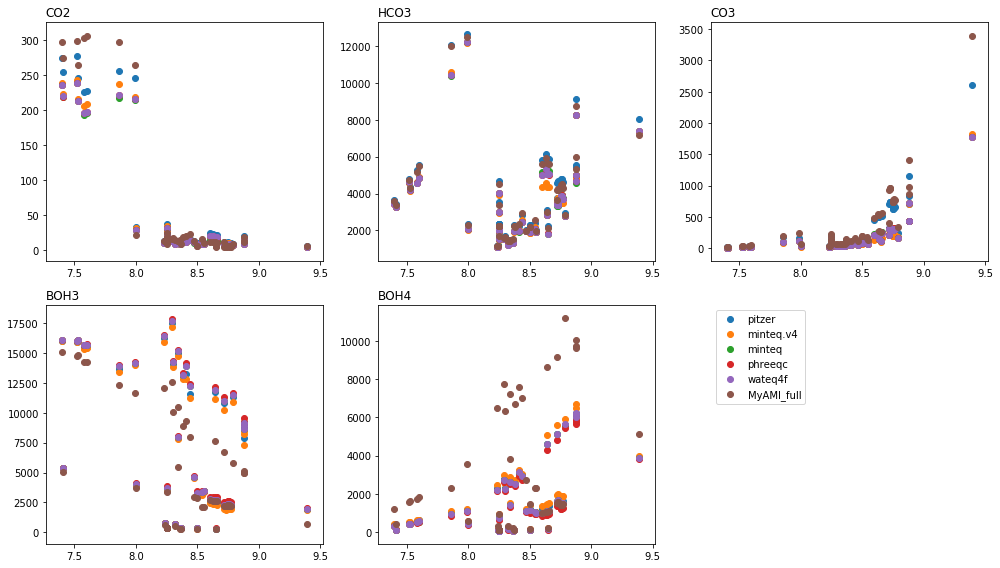

In [6]:
x = 'pH'

fig, axs = plt.subplots(2, 3, figsize=[14,8])

# for db in databases + ['MyAMI_eSal', 'MyAMI_full']:
# for db in ['MyAMI_full', 'pitzer', 'phreeqc', 'wateq4f']:
for db in databases + ['MyAMI_full']:
    axs[0,0].scatter(calc.loc[:, ('pitzer', x)], calc.loc[:, (db, 'CO2')] * 1e6)
    axs[0,1].scatter(calc.loc[:, ('pitzer', x)], calc.loc[:, (db, 'HCO3')] * 1e6)
    axs[0,2].scatter(calc.loc[:, ('pitzer', x)], calc.loc[:, (db, 'CO3')] * 1e6)
    
    axs[1,0].scatter(calc.loc[:, ('pitzer', x)], calc.loc[:, (db, 'BOH3')] * 1e6)
    axs[1,1].scatter(calc.loc[:, ('pitzer', x)], calc.loc[:, (db, 'BOH4')] * 1e6)
    
    axs[1,2].scatter([], [], label=db)

axs[0,0].set_title('CO2', loc='left')
axs[0,1].set_title('HCO3', loc='left')
axs[0,2].set_title('CO3', loc='left')
axs[1,0].set_title('BOH3', loc='left')
axs[1,1].set_title('BOH4', loc='left')

axs[1,2].axis('off')
axs[1,2].legend(loc='upper left')

fig.tight_layout()

There is considerable variation between the different methods. Which one should we choose?

The `minteq`, `wateq` and `phreeqc` databases calculate activity coefficients using the Davies equation (Davies, 1962), which is known to be unsuitable for low ionic strength solutions. The `pitzer` database uses a Pitzer aqueous model.

A marked difference between the different PHREEQC databases is in their inclusion/exclusion of ion-pairing effects:

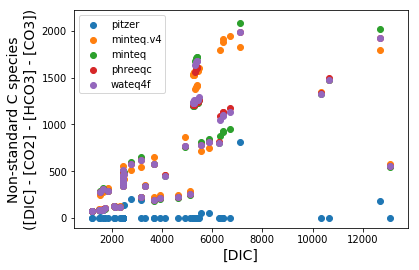

In [7]:
for db in databases:
    plt.scatter(calc.loc[:, (db, 'C')] * 1e6, 
                (calc.loc[:, (db, 'C')] - calc.loc[:, (db, 'CO2')] - calc.loc[:, (db, 'HCO3')] - calc.loc[:, (db, 'CO3')]) * 1e6,
                label=db)
plt.xlabel('[DIC]', fontsize=14)
plt.ylabel('Non-standard C species\n([DIC] - [CO2] - [HCO3] - [CO3])', fontsize=14)
plt.legend()

This shows significant differences between databases, depending on whether or not they include ion pairing.

## Accuracy of KB

As we are primarily concerned with B, a significant criteria to choose our calculation method must come from its ability to re-create measured KB values in different solutions.

In [8]:
# Measured pKB as a function of Ionic Strength

# from Dickson et al, 1990 in KCl
ion_str = [0.1,0.3,0.5,1]
pKB = [9.016,8.939,8.907,8.899]

# from Dickson et al, 1990 in Artificial Seawater
ion_str_2 = [0.1, 0.3, 0.5, 0.7, 0.9] 
pKB_2 = [8.921, 8.751, 8.656, 8.580, 8.530]

Text(0.635,9.2,'Kacz.')

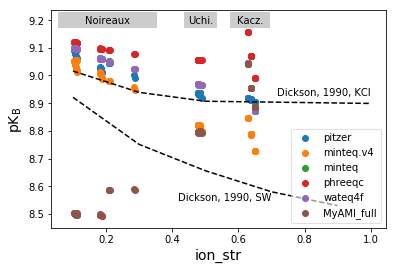

In [9]:
# sub = calc.loc[idx[:, 'Uchikawa', :], :]
sub = calc

x = 'ion_str'

for db in databases + ['MyAMI_full']:
    plt.scatter(sub.loc[:, ('pitzer', x)], 
                -np.log10((10**-sub.loc[:, ('pitzer', 'pH')] * 
                           sub.loc[:, (db, 'BOH4')] / 
                           sub.loc[:, (db, 'BOH3')]).astype(float)),
                label=db)
plt.xlabel(x, fontsize=14)
plt.ylabel('$pK_B$', fontsize=14)
plt.legend(framealpha=0.6, loc='lower right')

plt.plot(ion_str, pKB, c='k', ls='dashed')
plt.plot(ion_str_2, pKB_2, c='k', ls='dashed')

plt.text(1, 8.92, 'Dickson, 1990, KCl', ha='right', va='bottom')
plt.text(0.7, 8.54, 'Dickson, 1990, SW', ha='right', va='bottom')

lohi = (.08, .33)
plt.plot(lohi, [9.2, 9.2], lw=16, c=(0,0,0,0.2))
plt.text(np.mean(lohi), 9.2, 'Noireaux', va='center', ha='center', fontsize=10)

lohi = (.46, .51)
plt.plot(lohi, [9.2, 9.2], lw=16, c=(0,0,0,0.2))
plt.text(np.mean(lohi), 9.2, 'Uchi.', va='center', ha='center', fontsize=10)

lohi = (.6, .67)
plt.plot(lohi, [9.2, 9.2], lw=16, c=(0,0,0,0.2))
plt.text(np.mean(lohi), 9.2, 'Kacz.', va='center', ha='center', fontsize=10)

MyAMI doesn't work well for simple (non-seawater) solutions, and can't be modified easily to do so.

## Veracity of pKB under different solution chemistries

In [10]:
# load database of measured pKBs in different solutions.
pkbs = pd.read_excel('pKb-measurements.xlsx')
pkbs.replace(np.nan, 0, inplace=True)
pkbs.set_index(['reference', 'solution'], inplace=True)

pkbs.columns = pd.MultiIndex.from_product([['orig'],pkbs.columns])
pkbs.sort_index(inplace=True)

In [11]:
# calculate pKBs for all the measured conditions

databases = ['pitzer', 'minteq.v4', 'minteq', 'phreeqc', 'wateq4f']

pkcalc = []
for db in databases:
    dbsub = []
    for i, r in pkbs.orig.iterrows():
        out = pf.calc_cb(temp=r['T (°C)'],
                         pH=r['pH'],
                         Na=r['[Na] (m)'], 
                         Cl=r['[Cl] (m)'], 
                         K=r['[K] (m)'],
                         B=r['[B] (m)'],
                         Ca=r['[Ca] (m)'],
                         DIC=0,
                         Mg=r['[Mg] (m)'],
                         SO4=r['[SO4] (m)'],
                         dbase=db)
        out.name = i
        dbsub.append(out)
    dbsub = pd.concat(dbsub, 1).T
    dbsub.loc[:, 'pKB_free'] = -np.log10(10**-dbsub.loc[:, 'pH'] * dbsub.loc[:, 'BOH4_free'] / dbsub.loc[:, 'BOH3'])
    dbsub.loc[:, 'pKB'] = -np.log10(10**-dbsub.loc[:, 'pH'] * dbsub.loc[:, 'BOH4'] / dbsub.loc[:, 'BOH3'])
    dbsub.columns = pd.MultiIndex.from_product([[db], dbsub.columns])
    pkcalc.append(dbsub)

pkcalc = pd.concat(pkcalc, 1)

pkbs = pd.concat([pkcalc, pkbs], 1)

### Measured vs. Modelled pKB

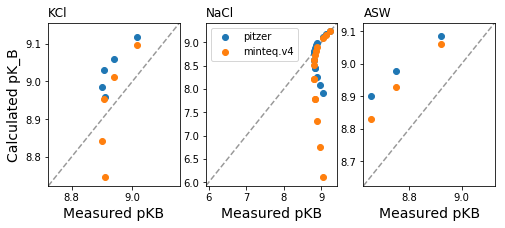

In [12]:
fig, axs = plt.subplots(1, 3, figsize=[8, 3])

x = 'pKB'
dbs = ['pitzer', 'minteq.v4']

for sol, ax in zip(['KCl', 'NaCl', 'ASW'], axs):
    sub = pkbs.loc[idx[:, sol] ,:]
    ax.set_title(sol, loc='left')
    for db in dbs:
        ax.scatter(sub.loc[:, ('orig', x)].values, sub.loc[:, (db, 'pKB')].values, label=db)
    ax.set_xlabel('Measured ' + x, fontsize=14)

axs[1].legend()
axs[0].set_ylabel('Calculated pK_B', fontsize=14)

for ax in axs:
    lims = ax.get_ylim()
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, c='k', ls='dashed', zorder=-1, alpha=0.4)

All methods are wrong in subtly different ways. We need a method that produces *consistent* results across the entire ionic strength range considered by existing precipitation studies.

## Performance over Experimental Range

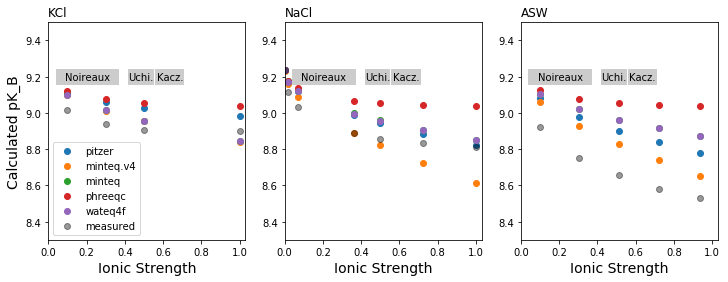

In [13]:
fig, axs = plt.subplots(1, 3, figsize=[12, 4])

x = 'Ion. Str. (I)'
xm = 1
# dbs = ['pitzer', 'minteq.v4']
dbs = databases

for sol, ax in zip(['KCl', 'NaCl', 'ASW'], axs):
    sub = pkbs.loc[idx[:, sol] ,:]
    ax.set_title(sol, loc='left')
    for db in dbs:
        ax.scatter(sub.loc[:, ('orig', x)].values * xm, sub.loc[:, (db, 'pKB')].values, label=db)
    ax.set_xlabel('Ionic Strength', fontsize=14)
    
    ax.scatter(sub.loc[:, ('orig', x)].values * xm,
               sub.loc[:, ('orig', 'pKB')].values,
               c='k', alpha=0.4, label='measured')

axs[0].legend()
axs[0].set_ylabel('Calculated pK_B', fontsize=14)


for ax in axs:
    ax.set_xlim(0, 1.03)
    ax.set_ylim(8.3, 9.5)
#     lims = ax.get_ylim()
#     ax.set_xlim(lims)
#     ax.set_ylim(lims)
#     ax.plot(lims, lims, c='k', ls='dashed', zorder=-1, alpha=0.4)

for ax in axs:
    y = 9.2
    lohi = (.08, .33)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Noireaux', va='center', ha='center', fontsize=10)

    lohi = (.46, .51)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Uchi.', va='center', ha='center', fontsize=10)

    lohi = (.6, .67)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Kacz.', va='center', ha='center', fontsize=10)

Across this range again, all models are wrong in different ways. The two consistently closest to measured values are the 'pitzer' and 'minteq.v4' databases. We'll pursue these further...

## Is ion-pairing important for KB?

i.e. whould we consider 'total' or 'free' B(OH)4?

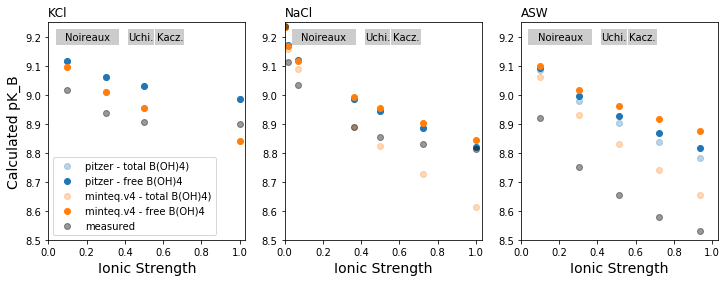

In [14]:
fig, axs = plt.subplots(1, 3, figsize=[12, 4])

x = 'Ion. Str. (I)'
xm = 1
dbs = ['pitzer', 'minteq.v4']
# dbs = databases

for sol, ax in zip(['KCl', 'NaCl', 'ASW'], axs):
    sub = pkbs.loc[idx[:, sol] ,:]
    ax.set_title(sol, loc='left')
    for db in dbs:
        pts = ax.scatter(sub.loc[:, ('orig', x)].values * xm, sub.loc[:, (db, 'pKB')].values, alpha=0.3, 
                         label=db + ' - total B(OH)4)')
        c = pts.get_facecolor().copy()
        c[0][-1] = 1
        ax.scatter(sub.loc[:, ('orig', x)].values * xm, sub.loc[:, (db, 'pKB_free')].values, label=db + ' - free B(OH)4', c=c)
    ax.set_xlabel('Ionic Strength', fontsize=14)
    
    ax.scatter(sub.loc[:, ('orig', x)].values * xm,
               sub.loc[:, ('orig', 'pKB')].values,
               c='k', alpha=0.4, label='measured')

axs[0].legend()
axs[0].set_ylabel('Calculated pK_B', fontsize=14)


for ax in axs:
    ax.set_xlim(0, 1.03)
    ax.set_ylim(8.5, 9.25)
#     lims = ax.get_ylim()
#     ax.set_xlim(lims)
#     ax.set_ylim(lims)
#     ax.plot(lims, lims, c='k', ls='dashed', zorder=-1, alpha=0.4)

for ax in axs:
    y = 9.2
    lohi = (.08, .33)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Noireaux', va='center', ha='center', fontsize=10)

    lohi = (.46, .51)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Uchi.', va='center', ha='center', fontsize=10)

    lohi = (.6, .67)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Kacz.', va='center', ha='center', fontsize=10)

Using 'total' B(OH)4 always produces calcualted KB values than 'free' B(OH)4.

### Include MyAMI in comparison

In [15]:
# exclude Hershed (ionic str range not useful)
pkbs = pkbs.iloc[pkbs.index.get_level_values(0) != 'Hershey (1986) GCA']

In [16]:
# in ASW
tmp = []
for i, r in pkbs.loc[idx[:,'ASW'],:].orig.iterrows():
    Ks = MyAMI_K_calc(TempC=r['T (°C)'],
                      Sal=r['Salinity'],
                      Na=r['[Na] (m)'], 
                      Cl=r['[Cl] (m)'], 
                      K=r['[K] (m)'],
                      B=r['[B] (m)'],
                      Ca=r['[Ca] (m)'],
                      HCO3=0, CO3=0,
                      Mg=r['[Mg] (m)'],
                      SO4=r['[SO4] (m)'])
    tmp.append(-np.log10(Ks.KB))

pkbs.loc[i, ('MyAMI_full', 'pKB')] = tmp

In [17]:
# In NaCl
tmp = []
for i, r in pkbs.loc[idx[:,'NaCl'],:].orig.iterrows():
    Ks = MyAMI_K_calc(TempC=r['T (°C)'],
                      Sal=r['Salinity'],
                      Na=r['[Na] (m)'], 
                      Cl=r['[Cl] (m)'], 
                      K=r['[K] (m)'],
                      B=r['[B] (m)'],
                      Ca=r['[Ca] (m)'],
                      HCO3=0, CO3=0,
                      Mg=r['[Mg] (m)'],
                      SO4=r['[SO4] (m)'])
    tmp.append(-np.log10(Ks.KB))
    
pkbs.loc[i, ('MyAMI_full', 'pKB')] = tmp

/home/oscar/GoogleDrive/MyPapers/_Revisions/Inorganic_B/Data/Supplement/inorg_b/MyAMI_V3.py:1371: RuntimeWarning: overflow encountered in power
  i * Sal**1.5))


In [18]:
# In KCl
tmp = []
for i, r in pkbs.loc[idx[:,'KCl'],:].orig.iterrows():
    Ks = MyAMI_K_calc(TempC=r['T (°C)'],
                      Sal=r['Salinity'],
                      Na=r['[Na] (m)'], 
                      Cl=r['[Cl] (m)'], 
                      K=r['[K] (m)'],
                      B=r['[B] (m)'],
                      Ca=r['[Ca] (m)'],
                      HCO3=0, CO3=0,
                      Mg=r['[Mg] (m)'],
                      SO4=r['[SO4] (m)'])
    tmp.append(-np.log10(Ks.KB))
    
pkbs.loc[i, ('MyAMI_full', 'pKB')] = tmp

### Full Comparison Plot

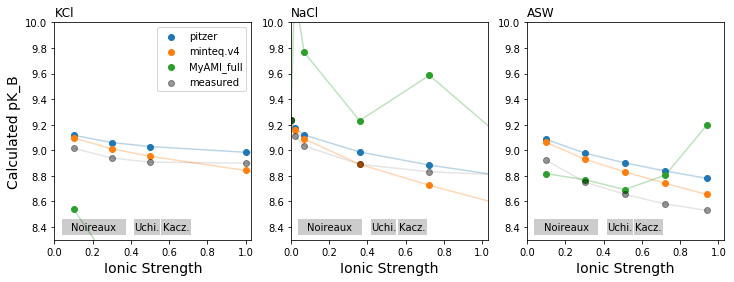

In [19]:
fig, axs = plt.subplots(1, 3, figsize=[12, 4])

x = 'Ion. Str. (I)'
xm = 1
dbs = ['pitzer', 'minteq.v4', 'MyAMI_full']
# dbs = databases

for sol, ax in zip(['KCl', 'NaCl', 'ASW'], axs):
    sub = pkbs.loc[idx[:, sol] ,:]
    ax.set_title(sol, loc='left')
    for db in dbs:
        ax.scatter(sub.loc[:, ('orig', x)].values * xm, sub.loc[:, (db, 'pKB')].values, label=db)
        ax.plot(sub.loc[:, ('orig', x)].values * xm, sub.loc[:, (db, 'pKB')].values, zorder=-1, alpha=0.3)
    ax.set_xlabel('Ionic Strength', fontsize=14)
    
    ax.scatter(sub.loc[:, ('orig', x)].values * xm,
               sub.loc[:, ('orig', 'pKB')].values,
               c='k', alpha=0.4, label='measured')
    ax.plot(sub.loc[:, ('orig', x)].values * xm,
            sub.loc[:, ('orig', 'pKB')].values,
            c='k', alpha=0.1, zorder=-1)

axs[0].legend()
axs[0].set_ylabel('Calculated pK_B', fontsize=14)


for ax in axs:
    ax.set_xlim(0, 1.03)
    ax.set_ylim(8.3, 10)
#     lims = ax.get_ylim()
#     ax.set_xlim(lims)
#     ax.set_ylim(lims)
#     ax.plot(lims, lims, c='k', ls='dashed', zorder=-1, alpha=0.4)

for ax in axs:
    y = 8.4
    lohi = (.08, .33)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Noireaux', va='center', ha='center', fontsize=10)

    lohi = (.46, .51)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Uchi.', va='center', ha='center', fontsize=10)

    lohi = (.6, .67)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Kacz.', va='center', ha='center', fontsize=10)

fig.savefig('../../Figures/S1_pKB_comparison.pdf')

MyAMI works OK in ASW solutions with ionic strength <= SW, but doesn't work at all in simple solutions.

In simple solutions, minteq.v4 appears to work marginally better, but its deviation from measured pKB changes with ionic strength, which precludes valid comparisons across the experimental range of ionic strengths.

We'll therefore go with the 'pitzer' database, which is clearly inaccurate, but is *consistently* inaccurate accross the range of ionic strengths employed by precipitation experiments.